In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline


## Import IOS Productivity data and create dataframe

In [2]:
df=pd.read_csv(r'/ocean/ksuchy/MOAD/observe/2023_SoG_FLC_Compiled.csv')

In [3]:
df

,Cruise,Event,Sample Number,Orig_Date,Date,Station,Depth (m),Orig_Lat,Orig_Long,Lat,...,GOPm (mmol O2 / m³ / h),JVPIIm ( µmol photons / m³ / s),"Max. PhytoPP (using ɸe,c of 4) (mmol C/m3/h )",Max. PhytoPP (using Redfield O:C; mmol C / m³ / h),aLHII,Daily Light Integral (mol photons / m2 / day),Total e- production (mol e- /m2/ day),Total C production * (mmol C/ m2/day ),Total C production * (g C /m2/day),[chl-a]ext (mg/m3)
0,2023-002,2,2,16-Feb-23,2/16/2023,GEO1,0,49 15.041,123 44.933,49.250683,...,0.3557,0.3952,0.35568,0.273,0.01245,4.900,0.10,15.30,0.20,0.71
1,2023-002,10,11,17-Feb-23,2/17/2023,BS-11,0,49 28.981,124 45.998,49.483017,...,0.4182,0.4647,0.41823,0.321,0.01264,8.700,0.10,27.50,0.30,0.58
2,2023-002,21,22,17-Feb-23,2/17/2023,12,5,49 43.568,124 40.834,49.726133,...,0.6615,0.7350,0.66150,0.508,0.01493,8.700,0.10,32.40,0.40,0.41
3,2023-002,24,24,18-Feb-23,2/18/2023,22,0,49 40.11,124 16.356,49.668500,...,0.3513,0.3904,0.35136,0.270,0.01259,10.000,0.10,31.60,0.40,0.62
4,2023-002,46,29,19-Feb-23,2/19/2023,42,0,49 1.723,123 26.2,49.028717,...,1.0430,1.1590,1.04310,0.801,0.01917,7.600,0.10,36.20,0.40,1.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2023-029,78,287,12-Oct-23,10/12/2023,12,0,49 43.593,124 40.668,49.726133,...,1.3250,1.4720,1.32480,1.018,0.01917,12.908,0.25,61.86,0.74,NaN
87,2023-029,78,285,12-Oct-23,10/12/2023,12,5,49 43.593,124 40.668,49.726133,...,1.1720,1.3020,1.17180,0.900,0.01880,12.908,0.24,60.67,0.73,NaN
88,2023-029,78,284,12-Oct-23,10/12/2023,12,10,49 43.593,124 40.668,49.726133,...,0.8816,0.9795,0.88155,0.677,0.01707,12.908,0.22,55.08,0.66,NaN
89,2023-029,78,283,12-Oct-23,10/12/2023,12,20,49 43.593,124 40.668,49.726133,...,0.7239,0.8043,0.72387,0.556,0.01313,12.908,0.17,42.37,0.51,NaN


In [4]:
df.keys()

Index(['Cruise', 'Event', 'Sample Number', 'Orig_Date', 'Date', 'Station',
       'Depth (m)', 'Orig_Lat', 'Orig_Long', 'Lat', 'Lon', 'Fo',
       'GOPm (mmol O2 / m³ / h)', 'JVPIIm ( µmol photons / m³ / s)',
       'Max. PhytoPP (using ɸe,c of 4) (mmol C/m3/h )',
       'Max. PhytoPP (using Redfield O:C;  mmol C / m³ / h)', 'aLHII',
       'Daily Light Integral (mol photons / m2 / day)',
       'Total e- production (mol e- /m2/ day)',
       'Total C production * (mmol C/ m2/day )',
       'Total C production * (g C /m2/day)', '[chl-a]ext (mg/m3)'],
      dtype='object')

In [5]:
df['Station'].unique()

array(['GEO1', 'BS-11', '12', '22', '42', '2', 'SC-04', '27', '63', '59'],
      dtype=object)

In [6]:
df['Date']

0      2/16/2023
1      2/17/2023
2      2/17/2023
3      2/18/2023
4      2/19/2023
         ...    
86    10/12/2023
87    10/12/2023
88    10/12/2023
89    10/12/2023
90    10/13/2023
Name: Date, Length: 91, dtype: object

## Figure showing observation locations of IOS sampling

In [7]:
import netCDF4 as nc

In [8]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

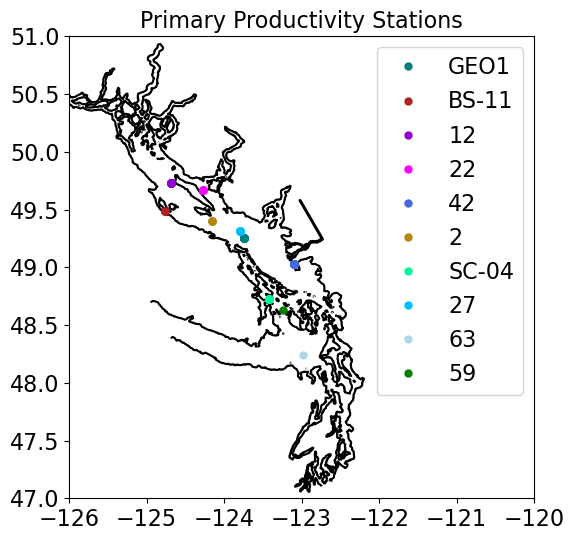

In [99]:


fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','firebrick','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue','green','darkorange')
datreg=dict()
for ind, iregion in enumerate(df.Station.unique()):
    datreg[iregion] = df.loc[df.Station==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion,markersize=10)
ax.set_ylim(47,51)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120);
ax.set_title('Primary Productivity Stations');
ax.legend(bbox_to_anchor=(1, 1))


In [10]:
df['Date']=df['Date'].astype('string')

In [11]:
df['Date']=pd.to_datetime(df.Date, format='%m/%d/%Y')

In [12]:
df['Month'] = df['Date'].dt.month

In [13]:
df['Depth (m)']

0      0
1      0
2      5
3      0
4      0
      ..
86     0
87     5
88    10
89    20
90     0
Name: Depth (m), Length: 91, dtype: int64

In [14]:
#df = df.rename(columns={'Depth (m)': 'Depth'})


In [82]:
Surface=df.loc[(df['Depth (m)']==5)]

In [83]:
monthlymean=Surface.groupby(['Month']).mean()

In [84]:
monthlymean.keys()

Index(['Event', 'Sample Number', 'Depth (m)', 'Lat', 'Lon', 'Fo',
       'GOPm (mmol O2 / m³ / h)', 'JVPIIm ( µmol photons / m³ / s)',
       'Max. PhytoPP (using ɸe,c of 4) (mmol C/m3/h )',
       'Max. PhytoPP (using Redfield O:C;  mmol C / m³ / h)', 'aLHII',
       'Daily Light Integral (mol photons / m2 / day)',
       'Total e- production (mol e- /m2/ day)',
       'Total C production * (mmol C/ m2/day )',
       'Total C production * (g C /m2/day)', '[chl-a]ext (mg/m3)'],
      dtype='object')

In [85]:
monthlysem=df.groupby(['Month']).sem()

In [86]:
GEO1=df.loc[(df.Station=='GEO1')]
BS11=df.loc[(df.Station=='BS-11')]
STN12=df.loc[(df.Station=='12')]
STN22=df.loc[(df.Station=='22')]
STN42=df.loc[(df.Station=='42')]
STN2=df.loc[(df.Station=='2')]
SC04=df.loc[(df.Station=='SC-04')]
STN27=df.loc[(df.Station=='27')]
STN63=df.loc[(df.Station=='63')]
STN59=df.loc[(df.Station=='59')]

In [87]:
monthlymeanGEO1=GEO1.groupby(['Month']).mean()
monthlymeanBS11=BS11.groupby(['Month']).mean() # leave out
monthlymeanSTN12=STN12.groupby(['Month']).mean()
monthlymeanSTN22=STN22.groupby(['Month']).mean()
monthlymeanSTN42=STN42.groupby(['Month']).mean()
monthlymeanSTN2=STN2.groupby(['Month']).mean() #not all months are there
monthlymeanSC04=SC04.groupby(['Month']).mean()
monthlymeanSTN27=STN27.groupby(['Month']).mean()
monthlymeanSTN63=STN63.groupby(['Month']).mean() #only one month
monthlymeanSTN59=STN59.groupby(['Month']).mean() #only one month

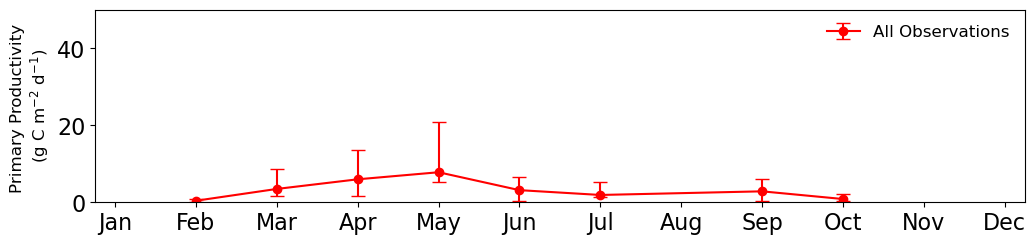

In [88]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named


ax.errorbar(monthlymean.index,((monthlymean['Total C production * (g C /m2/day)'])),
               yerr=(np.array([(monthlymean['Total C production * (g C /m2/day)']-monthlysem['Total C production * (g C /m2/day)']),
                 (monthlymean['Total C production * (g C /m2/day)']+monthlysem['Total C production * (g C /m2/day)'])])),
              fmt='r-o',capsize=5,color='blue',label='All Observations')


ax.set_ylim(0,50)
ax.set_xlim(0.75,12.25)
ax.set_title('')
ax.set_ylabel('Primary Productivity \n(g C m$^{-2}$ d$^{-1}$)',fontsize=12)
ax.legend(fontsize=12,frameon=False,bbox_to_anchor=(1., 1.0))
#fig.savefig('.png',bbox_inches='tight')

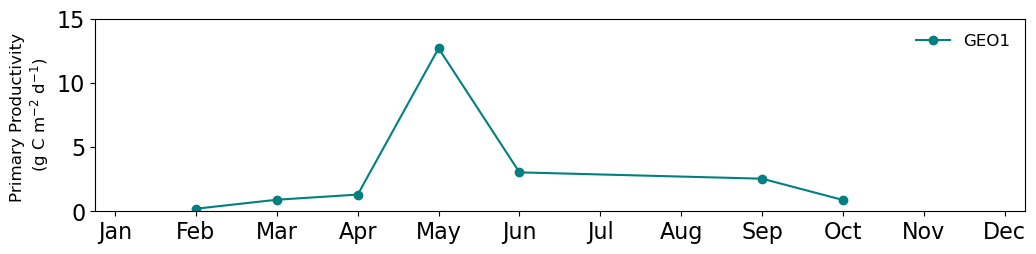

In [105]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))

#'teal','firebrick','darkviolet','fuchsia',
#        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue','green','darkorange'

ax.plot(monthlymeanGEO1.index,((monthlymeanGEO1['Total C production * (g C /m2/day)'])),\
            color='teal',linestyle='-',marker='o',label='GEO1')
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named
ax.set_ylim(0,15)
ax.set_xlim(0.75,12.25)
ax.set_ylabel('Primary Productivity \n(g C m$^{-2}$ d$^{-1}$)',fontsize=12)
ax.legend(fontsize=12,frameon=False,bbox_to_anchor=(1., 1.0))

#ax.plot(monthlymeanSTN42.index,((monthlymeanSTN42['Total C production * (g C /m2/day)'])),\
#            color='teal',linestyle='-',marker='o',label='STN 42')



#fig.set_title('')
#fig.savefig('.png',bbox_inches='tight')

In [97]:
print(monthlymeanGEO1['Total C production * (g C /m2/day)'])

Month
2      0.200000
3      0.900000
4      1.300000
5     12.700000
6      3.033333
9      2.540000
10     0.880000
Name: Total C production * (g C /m2/day), dtype: float64


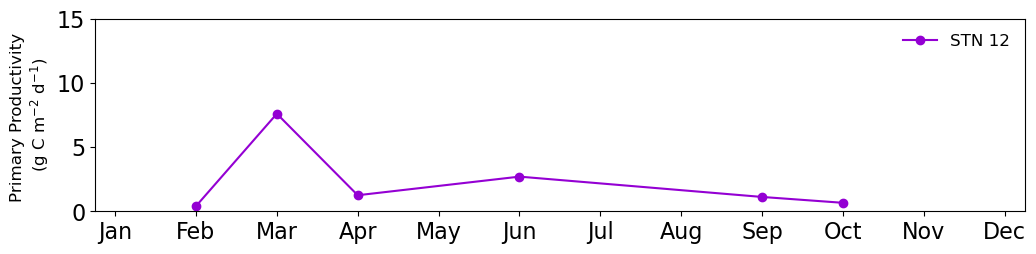

In [104]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))

#'teal','firebrick','darkviolet','fuchsia',
#        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue','green','darkorange'

ax.plot(monthlymeanSTN12.index,((monthlymeanSTN12['Total C production * (g C /m2/day)'])),\
            color='darkviolet',linestyle='-',marker='o',label='STN 12')

ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named
ax.set_ylim(0,15)
ax.set_xlim(0.75,12.25)
ax.set_ylabel('Primary Productivity \n(g C m$^{-2}$ d$^{-1}$)',fontsize=12)
ax.legend(fontsize=12,frameon=False,bbox_to_anchor=(1., 1.0))

#ax.plot(monthlymeanSTN42.index,((monthlymeanSTN42['Total C production * (g C /m2/day)'])),\
#            color='teal',linestyle='-',marker='o',label='STN 42')



#fig.set_title('')
#fig.savefig('.png',bbox_inches='tight')

In [98]:
monthlymeanSTN12['Total C production * (g C /m2/day)']

Month
2     0.400000
3     7.600000
4     1.250000
6     2.700000
9     1.116667
10    0.660000
Name: Total C production * (g C /m2/day), dtype: float64

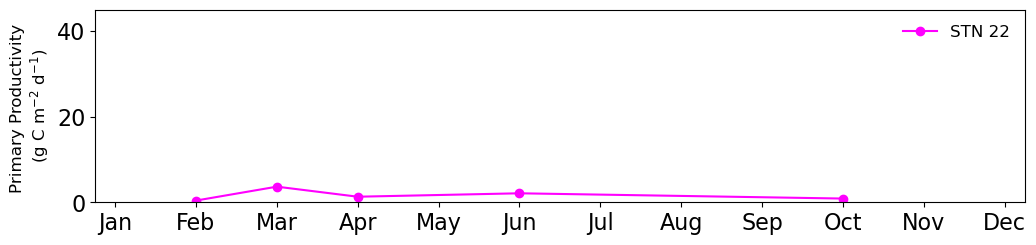

In [91]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))

#'teal','firebrick','darkviolet','fuchsia',
#        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue','green','darkorange'

ax.plot(monthlymeanSTN22.index,((monthlymeanSTN22['Total C production * (g C /m2/day)'])),\
            color='fuchsia',linestyle='-',marker='o',label='STN 22')

ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named
ax.set_ylim(0,45)
ax.set_xlim(0.75,12.25)
ax.set_ylabel('Primary Productivity \n(g C m$^{-2}$ d$^{-1}$)',fontsize=12)
ax.legend(fontsize=12,frameon=False,bbox_to_anchor=(1., 1.0))

#ax.plot(monthlymeanSTN42.index,((monthlymeanSTN42['Total C production * (g C /m2/day)'])),\
#            color='teal',linestyle='-',marker='o',label='STN 42')



#fig.set_title('')
#fig.savefig('.png',bbox_inches='tight')

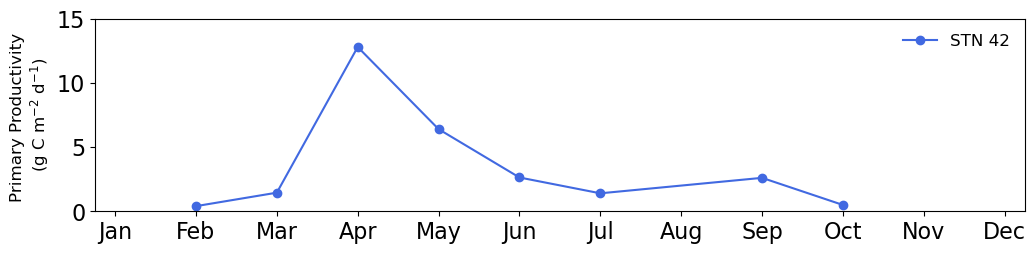

In [103]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))

#'teal','firebrick','darkviolet','fuchsia',
#        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue','green','darkorange'

ax.plot(monthlymeanSTN42.index,((monthlymeanSTN42['Total C production * (g C /m2/day)'])),\
            color='royalblue',linestyle='-',marker='o',label='STN 42')

ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named
ax.set_ylim(0,15)
ax.set_xlim(0.75,12.25)
ax.set_ylabel('Primary Productivity \n(g C m$^{-2}$ d$^{-1}$)',fontsize=12)
ax.legend(fontsize=12,frameon=False,bbox_to_anchor=(1., 1.0))

#ax.plot(monthlymeanSTN42.index,((monthlymeanSTN42['Total C production * (g C /m2/day)'])),\
#            color='teal',linestyle='-',marker='o',label='STN 42')



#fig.set_title('')
#fig.savefig('.png',bbox_inches='tight')

In [96]:
print(monthlymeanSTN42['Total C production * (g C /m2/day)'])

Month
2      0.400000
3      1.450000
4     12.800000
5      6.400000
6      2.633333
7      1.400000
9      2.605000
10     0.492500
Name: Total C production * (g C /m2/day), dtype: float64


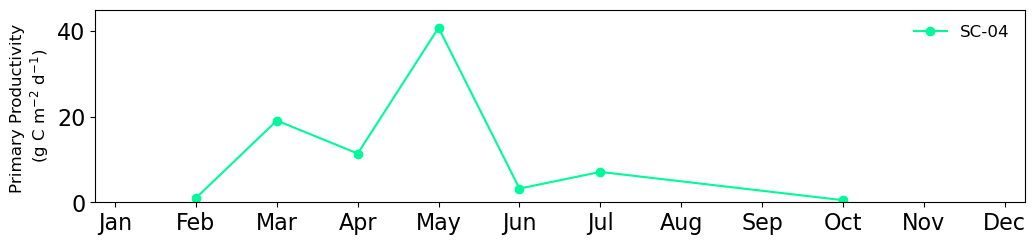

In [93]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))

#'teal','firebrick','darkviolet','fuchsia',
#        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue','green','darkorange'

ax.plot(monthlymeanSC04.index,((monthlymeanSC04['Total C production * (g C /m2/day)'])),\
            color='mediumspringgreen',linestyle='-',marker='o',label='SC-04')

ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named
ax.set_ylim(0,45)
ax.set_xlim(0.75,12.25)
ax.set_ylabel('Primary Productivity \n(g C m$^{-2}$ d$^{-1}$)',fontsize=12)
ax.legend(fontsize=12,frameon=False,bbox_to_anchor=(1., 1.0))

#ax.plot(monthlymeanSTN42.index,((monthlymeanSTN42['Total C production * (g C /m2/day)'])),\
#            color='teal',linestyle='-',marker='o',label='STN 42')



#fig.set_title('')
#fig.savefig('.png',bbox_inches='tight')

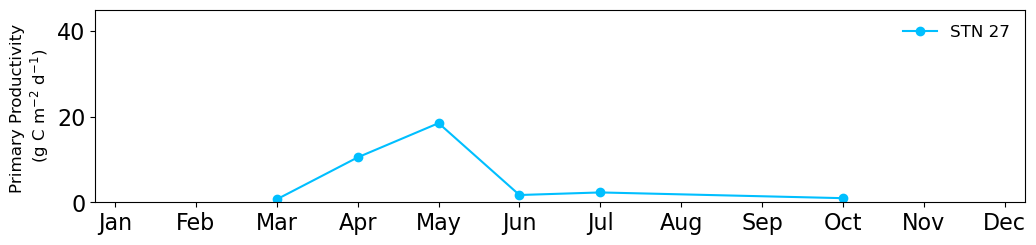

In [94]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))

#'teal','firebrick','darkviolet','fuchsia',
#        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue','green','darkorange'

ax.plot(monthlymeanSTN27.index,((monthlymeanSTN27['Total C production * (g C /m2/day)'])),\
            color='deepskyblue',linestyle='-',marker='o',label='STN 27')

ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named
ax.set_ylim(0,45)
ax.set_xlim(0.75,12.25)
ax.set_ylabel('Primary Productivity \n(g C m$^{-2}$ d$^{-1}$)',fontsize=12)
ax.legend(fontsize=12,frameon=False,bbox_to_anchor=(1., 1.0))

#ax.plot(monthlymeanSTN42.index,((monthlymeanSTN42['Total C production * (g C /m2/day)'])),\
#            color='teal',linestyle='-',marker='o',label='STN 42')



#fig.set_title('')
#fig.savefig('.png',bbox_inches='tight')